Para entrar no modo apresentação, execute a seguinte célula e pressione `-`

In [1]:
%reload_ext slide

<IPython.core.display.Javascript object>

<span class="notebook-slide-start"/>

# Pygit2

Este notebook apresenta os seguintes tópicos:

- [Pygit2](#Pygit2)
- [Exercício 11](#Exerc%C3%ADcio-11)


Conseguimos extrair informações do git usando comandos de sistema e parseando os resultados como fizemos anteriormente.

Porém, comandos de sistema nem sempre são a alternativa mais rápida e existe um esforço em parsear as informações.

Nesta parte do minicurso, falarei da biblioteca `pygit2`, que permite acessar e extrair informações diretamente do repositório.

Inicialmente, vamos carregar o repositório. <span class="notebook-slide-extra" data-count="3"/>

In [2]:
import pygit2

In [3]:
%cd sapos
repo_path = pygit2.discover_repository(".")
repo_path

/home/joao/projects/tutorial/sapos


'/home/joao/projects/tutorial/sapos/.git/'

In [4]:
repo = pygit2.Repository(repo_path)

A partir do objeto do repositório, podemos ver em que commit ou tag estamos. <span class="notebook-slide-extra" data-count="1"/>

In [5]:
repo.describe()

'4.4.27'

Note que o resultado foi a última tag que fizemos checkout, que também é o branch `master`. <span class="notebook-slide-scroll" data-position="-1"/>

Podemos fazer checkout de commits usando a `pygit2`. <span class="notebook-slide-extra" data-count="2"/>

In [6]:
commit = repo.revparse_single("e82315c3ef")
repo.checkout_tree(
    commit,
)
repo.set_head(commit.oid)

In [7]:
repo.describe()

'4.0.0'

O checkout de branches é mais simples. <span class="notebook-slide-extra" data-count="2"/>

In [8]:
master = repo.lookup_branch("master")
repo.checkout(master)

In [9]:
repo.describe()

'4.4.27'

Com um objeto de commit, podemos extrair informações dele. <span class="notebook-slide-extra" data-count="5"/>

In [10]:
commit.oid

e82315c3efeb7b29dd43792fd77d840c229d7dcb

In [11]:
commit.author.name, commit.author.email

('Joao Felipe', 'joaofelipenp@gmail.com')

In [12]:
commit.commit_time

1409504044

In [13]:
commit.message

"Merge tag '4.0.0-migration'\n"

In [14]:
commit.parent_ids

[b3d4c3780c06255346ce42d1df7aacb22827c90a,
 3b8122326f5e8ffddd7888d2e601ff17e412e871]

Note que por ser um merge, o commit possui dois pais. <span class="notebook-slide-scroll" data-count="-1"/>

A `pygit2` também possui funções para caminhar pelos commits do repositório. <span class="notebook-slide-extra" data-count="1"/>

In [15]:
last_commit = repo[repo.head.target]
i = 0
for commit in repo.walk(last_commit.id, pygit2.GIT_SORT_TIME):
    print(str(commit.id)[:8], commit.message)
    i += 1
    if i >= 3:
        break

d3e43077 #300 updating devise gem from 4.6.2 to 4.7.1 due security vulnerability

0f5588e3 #299 updating nokogiri gem from 1.10.1 to 1.10.4 due security vulnerability

ae8746e8 Merge branch 'bugfixes'



A forma de caminhar pode variar de acordo com o segundo argumento:
    
- `GIT_SORT_NONE`: Sem ordem determinada
- `GIT_SORT_TOPOLOGICAL`: Ordem topológica - pais antes de filhos
- `GIT_SORT_TIME`: Momento do commit
- `GIT_SORT_REVERSE`: Ordem inversa

Esses argumentos podem ser combinados. Se eu quiser caminhar no inverso da ordem dos commits, posso fazer:
```python
    GIT_SORT_TIME | GIT_SORT_REVERSE
```

A seguir, usamos essa forma combinada para pegar o primeiro commit do projeto. <span class="notebook-slide-extra" data-count="1"/>

In [16]:
order = pygit2.GIT_SORT_TIME | pygit2.GIT_SORT_REVERSE
it = iter(repo.walk(last_commit.id, order))
first_commit = next(it)
first_commit.id, first_commit.message

(cf1efe3addbd8bc8208ca687c14f3181588e9ff0, 'Files generated by rails new.')

Podemos usar essa navegação para contar a quantidade de commits no histórico. <span class="notebook-slide-extra" data-count="1"/>

In [17]:
len(list(repo.walk(last_commit.id)))

1391

Mas note que esse não é o número total de commits do projeto! Ele apenas representa o número de commits no histórico do último commit.

Outros commits podem estar em branches ou até mesmo pendurados. <span class="notebook-slide-scroll" data-position="-1"/>

Para pegar todos os commits, precisamos iterar nos objetos do git e selecionar objetos que são commits. <span class="notebook-slide-extra" data-count="2"/>

In [18]:
commits = []
for oid in repo:
    obj = repo.get(oid)
    if isinstance(obj, pygit2.Commit):
        commits.append(obj)

In [19]:
len(commits)

1412

Agora temos todos os commits. <span class="notebook-slide-scroll" data-position="-1"/>

Em seguida, tentamos descobrir quais são os commits que não estão no histórico do `master`. <span class="notebook-slide-extra" data-count="1"/>

In [20]:
diff = set(commits) - set(repo.walk(last_commit.id))
for commit, _ in zip(diff, range(5)):
    print(str(commit.id)[:8], commit.message)


5b5b9624 Atualizando active_scaffold

5ce0ed0c Criacao de alguns testes de logins

69b272da #254 adding a variable to enable or disable if professors can post grades

4c35a7f3 Adicionando gems de testes

7098c4a4 Removendo rails-erd que não funciona mais no projeto.



Quanto listamos os branches no início deste notebook, apenas o `reports` e `bugfixes` não estavam no mesmo commit que o `master`. Desta forma, podemos ver se os commits que não estão no `master` são commits do `reports`, do `bugfixes`, ou se estão pendurados.

A seguir verificamos quais commits não são de `reports`. <span class="notebook-slide-extra" data-count="1"/>

In [21]:
new_diff = diff - set(repo.walk(repo.revparse_single("reports").id))
for commit in new_diff:
    print(str(commit.id)[:8], commit.message)

70cccb2d #298 adding create header labels to pages that did not have them

69b272da #254 adding a variable to enable or disable if professors can post grades

50f1f600 #297 adding rspec presence tests to model Query and fixing them

4d221761 #296 implementing query_param_spec and fixing query_param bugs



Em seguida, verificados se tem algum dos commits que não é de `bugfixes`. <span class="notebook-slide-extra" data-count="1"/>

In [22]:
new_diff = new_diff - set(repo.walk(repo.revparse_single("bugfixes").id))
for commit in new_diff:
    print(str(commit.id)[:8], commit.message)

Como não teve nenhum resultado, sabemos que todos os commits que não estão no master são de `reports` ou `bugfixes`. <span class="notebook-slide-scroll" data-position="-1"/>

Outra coisa que podemos fazer com a navegação nos commits é construir uma linha do tempo mostrando quais foram os momentos em que ocorreram mais commits.

Começamos calculando quantos dias se passaram desde o primeiro commit até hoje, preparando um array de dias, e inicializando um array de zeros. <span class="notebook-slide-extra" data-count="2"/>

In [23]:
from datetime import datetime
first_date = datetime.fromtimestamp(first_commit.commit_time)
first_date

datetime.datetime(2011, 7, 18, 10, 2, 10)

In [24]:
import numpy as np
today = datetime.today()
delta = today - first_date
days = delta.days
indexes = np.arange(days)
values = np.zeros(days)
days

3021

Navegamos nos commits atualizando values para considerar a contribuição de cada commit novo. <span class="notebook-slide-extra" data-count="1"/>

In [25]:
for commit in commits:
    date = datetime.fromtimestamp(commit.commit_time)
    delta = date - first_date
    delta_index = delta.days
    values[delta_index:] += 1

Plotamos o gráfico. <span class="notebook-slide-extra" data-count="1"/>

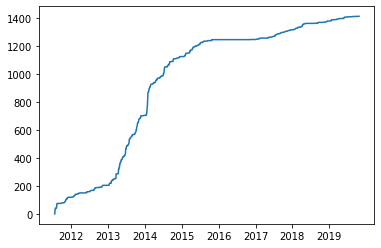

In [26]:
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

labels = [datetime(2011 + i, 1, 1) for i in range(ceil(delta.days / 365))]
label_indexes = [(label - first_date).days for label in labels]
label_years = [label.year for label in labels]
plt.xticks(label_indexes, label_years)
plt.plot(indexes, values)
plt.show()

## Exercício 11

Faça um gráfico mostrando o histórico de contribuições de cada usuário. <span class="notebook-slide-extra" data-count="2"/>

In [27]:
...

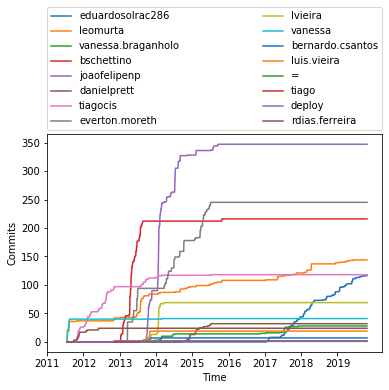

In [28]:
bottom = np.zeros(days)
legend_color = []
legend_text = []
...

plt.xticks(label_indexes, label_years)
plt.xlabel("Time")
plt.ylabel("Commits")
plt.legend(
    legend_color, legend_text,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=2
)
plt.show()

Continua: [10.Visualizacao.Rica.ipynb](10.Visualizacao.Rica.ipynb)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;


&nbsp;

&nbsp;

&nbsp;

